<center><h1> - Tabular Playground Series - Sep 2022 - </h1></center>
<b>Goal</b>: Predicting book sales during the year 2021 for 4 items from two competing stores located in six different countries.

### ⬇ Libraries

In [412]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

💡 <b> Insights from data exploration </b>
- Data after 2020 is intrinsically different from the years before. Therefore, I tend to not include it in the model.
- Include time dependency as some sort of cosine or sine function is essential at least for ANN's, RNN's but less for CNN's
- The country does not have any influence after 2020.
- Sales in the two store differ only by a constant factor.


<b> Things to test: </b>
- Use only data from 2020 onward
- Use only data from before
- Mix data (But I don't think this will lead to any good results as distribution is totally different?)

<b> Things to keep in mind </b>
- Remove last day in Feb. of leap year

### Folders

In [413]:
PROJECT_DIR = os.path.join(".")
DATASET_DIR = os.path.join(PROJECT_DIR, "dataset")

### Hyperparameters

In [414]:
# Amount of rows we have per day
ROWS_PER_DAY  = 4 * 2 * 6
DAYS_PER_WEEK = 7
# Leap year day will be ignored as we only predict data for 2021
DAYS_PER_YEAR = 365 

### Load dataset

In [415]:
train_df = pd.read_csv(os.path.join(DATASET_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATASET_DIR, "test.csv"))
# Convert column types
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

### Drop Leap year day

In [416]:
print("Before dropping training data shape is: ", train_df.shape)
train_df = train_df[train_df.date != pd.Timestamp("2020-02-29")]
train_df = train_df[train_df.date != pd.Timestamp("2020-02-29")]
train_df
print("After dropping training data shape is: ", train_df.shape)

Before dropping training data shape is:  (70128, 6)
After dropping training data shape is:  (70080, 6)


In [417]:
train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [418]:
test_df.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


### Add weekly and yearly seasonality information

In [419]:
# Note: As weeks don't end after 1 year it is important to count the day indices from the 
# beginning of the train all the way to the end of the test set.
day_indices = np.array([i // ROWS_PER_DAY for i in range(0, len(train_df) + len(test_df))])
# Seperate indices
day_indices_train = day_indices[:len(train_df)]
day_indices_test = day_indices[len(train_df):]

#day_indices_test = np.array([i // ROWS_PER_DAY for i in range(0, len(test_df))])
assert len(day_indices_train) == train_df.shape[0]
assert len(day_indices_test) == test_df.shape[0]

In [420]:
# Add seasonality information as sine & cosine to train & test dataset
# Note: Substract 1 as we start counting from 0
train_df['week_sin'] = np.sin(day_indices_train * (2 * np.pi / (DAYS_PER_WEEK - 1)))
train_df['week_cos'] = np.cos(day_indices_train * (2 * np.pi / (DAYS_PER_WEEK - 1)))
train_df['year_sin'] = np.sin(day_indices_train * (2 * np.pi / (DAYS_PER_YEAR - 1)))
train_df['year_cos'] = np.cos(day_indices_train * (2 * np.pi / (DAYS_PER_YEAR - 1)))

test_df['week_sin'] = np.sin(day_indices_test * (2 * np.pi / (DAYS_PER_WEEK - 1)))
test_df['week_cos'] = np.cos(day_indices_test * (2 * np.pi / (DAYS_PER_WEEK - 1)))
test_df['year_sin'] = np.sin(day_indices_test * (2 * np.pi / (DAYS_PER_YEAR - 1)))
test_df['year_cos'] = np.cos(day_indices_test * (2 * np.pi / (DAYS_PER_YEAR - 1)))

### Plot result

<b> Note: </b> 
- It is clear that the indices are correct as the week cycle continues in the test set

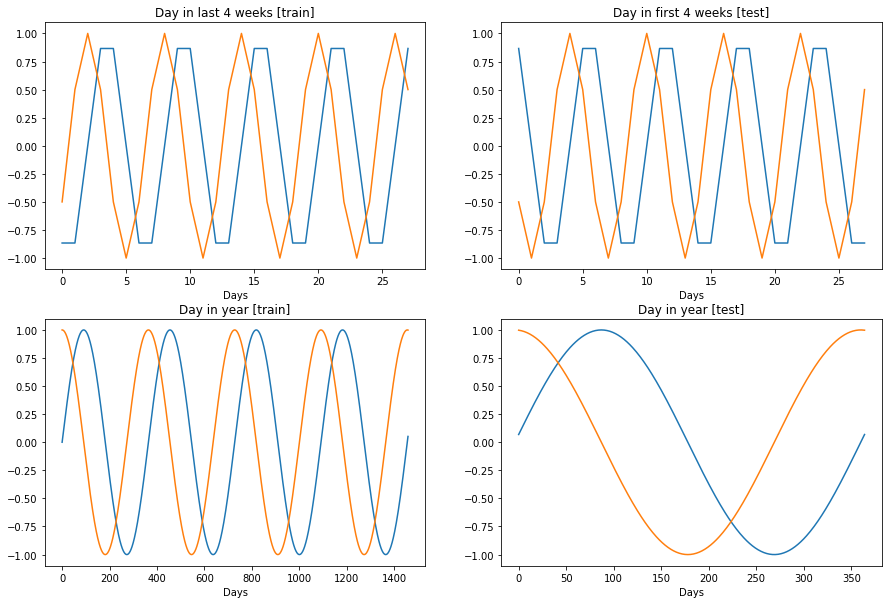

In [421]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
axes[0][0].set_title('Day in last 4 weeks [train]')
axes[0][0].set_xlabel('Days')
axes[0][0].plot(np.array(train_df['week_sin'])[::ROWS_PER_DAY][-28:])
axes[0][0].plot(np.array(train_df['week_cos'])[::ROWS_PER_DAY][-28:])
axes[0][1].set_title('Day in first 4 weeks [test]')
axes[0][1].set_xlabel('Days')
axes[0][1].plot(np.array(test_df['week_sin'])[::ROWS_PER_DAY][:28])
axes[0][1].plot(np.array(test_df['week_cos'])[::ROWS_PER_DAY][:28])
axes[1][0].set_title('Day in year [train]')
axes[1][0].set_xlabel('Days')
axes[1][0].plot(np.array(train_df['year_sin'])[::ROWS_PER_DAY])
axes[1][0].plot(np.array(train_df['year_cos'])[::ROWS_PER_DAY])
axes[1][1].set_title('Day in year [test]')
axes[1][1].set_xlabel('Days')
axes[1][1].plot(np.array(test_df['year_sin'])[::ROWS_PER_DAY])
axes[1][1].plot(np.array(test_df['year_cos'])[::ROWS_PER_DAY])

## 💡 Idea 1
- Data distribution in years before 2020 is different to 2020. 
- Assuming that the year 2021 will be similar to 2020 as COVID was still active let's focus on the year 2020 as training data.
- In the year 2020 we saw that the country does <b> not </b> have any impact on the sales. What does matter is the store and the product.
- We also learned from EDA that the daily per product sales are reasonably identical across the two shops. Therefore, by multiplying the Rama store sales by `2.88` we obatin the Mart store sales.
- To conclude let's
    - use data for later than 01.01.2020
    - average the sales over the country
    - multiply Rama store by `2.885` & average per product = normalise both and average per product.

### Use data later than 01.01.2020 for training

In [422]:
train_df_prep = train_df[train_df["date"] >= pd.Timestamp("2020-01-01")]
test_df_prep = test_df.copy(deep = True)

### Average sales over country

In [423]:
train_df_prep = train_df_prep.groupby(['date','store','product']).agg({
    'num_sold': 'mean',
    'year_cos': 'first',
    'year_sin': 'first',
    'week_sin': 'first',
    'week_cos': 'first',
}).reset_index()

test_df_prep = test_df_prep.groupby(['date','store','product']).agg({
    'year_cos': 'first',
    'year_sin': 'first',
    'week_sin': 'first',
    'week_cos': 'first',
}).reset_index()

In [424]:
train_df_prep.head()

,date,store,product,num_sold,year_cos,year_sin,week_sin,week_cos
0,2020-01-01,KaggleMart,Kaggle Advanced Techniques,387.166667,0.998659,0.051761,1.832554e-13,-1.0
1,2020-01-01,KaggleMart,Kaggle Getting Started,321.166667,0.998659,0.051761,1.832554e-13,-1.0
2,2020-01-01,KaggleMart,Kaggle Recipe Book,274.500000,0.998659,0.051761,1.832554e-13,-1.0
3,2020-01-01,KaggleMart,Kaggle for Kids: One Smart Goose,427.000000,0.998659,0.051761,1.832554e-13,-1.0
4,2020-01-01,KaggleRama,Kaggle Advanced Techniques,133.166667,0.998659,0.051761,1.832554e-13,-1.0


In [425]:
test_df_prep.head()

,date,store,product,year_cos,year_sin,week_sin,week_cos
0,2021-01-01,KaggleMart,Kaggle Advanced Techniques,0.997617,0.068991,0.866025,-0.5
1,2021-01-01,KaggleMart,Kaggle Getting Started,0.997617,0.068991,0.866025,-0.5
2,2021-01-01,KaggleMart,Kaggle Recipe Book,0.997617,0.068991,0.866025,-0.5
3,2021-01-01,KaggleMart,Kaggle for Kids: One Smart Goose,0.997617,0.068991,0.866025,-0.5
4,2021-01-01,KaggleRama,Kaggle Advanced Techniques,0.997617,0.068991,0.866025,-0.5


#### Plot to make sure the week cycles align

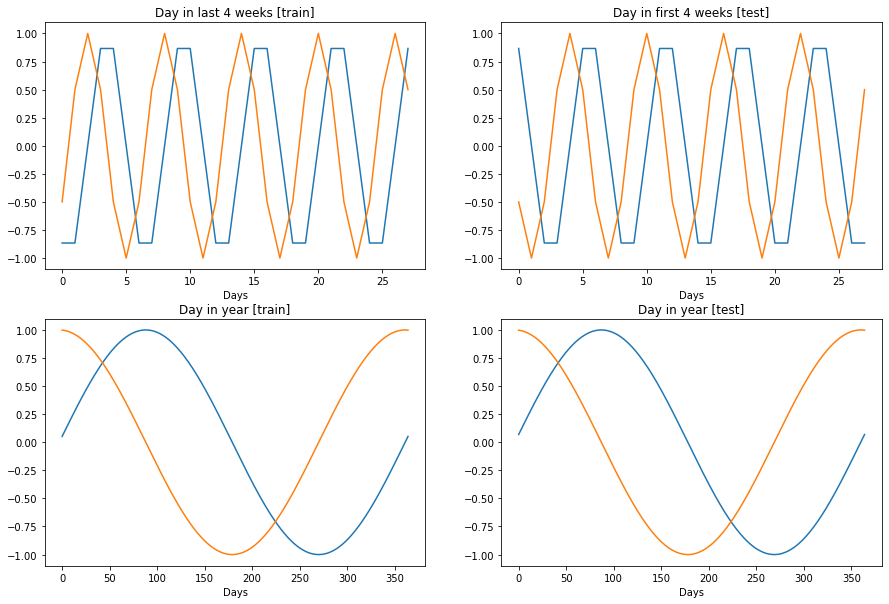

In [426]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
axes[0][0].set_title('Day in last 4 weeks [train]')
axes[0][0].set_xlabel('Days')
axes[0][0].plot(np.array(train_df_prep['week_sin'])[::8][-28:])
axes[0][0].plot(np.array(train_df_prep['week_cos'])[::8][-28:])
axes[0][1].set_title('Day in first 4 weeks [test]')
axes[0][1].set_xlabel('Days')
axes[0][1].plot(np.array(test_df_prep['week_sin'])[::8][:28])
axes[0][1].plot(np.array(test_df_prep['week_cos'])[::8][:28])
axes[1][0].set_title('Day in year [train]')
axes[1][0].set_xlabel('Days')
axes[1][0].plot(np.array(train_df_prep['year_sin'])[::8])
axes[1][0].plot(np.array(train_df_prep['year_cos'])[::8])
axes[1][1].set_title('Day in year [test]')
axes[1][1].set_xlabel('Days')
axes[1][1].plot(np.array(test_df_prep['year_sin'])[::8])
axes[1][1].plot(np.array(test_df_prep['year_cos'])[::8])

### Normalise and take mean

In [427]:
train_df_prep.head()

,date,store,product,num_sold,year_cos,year_sin,week_sin,week_cos
0,2020-01-01,KaggleMart,Kaggle Advanced Techniques,387.166667,0.998659,0.051761,1.832554e-13,-1.0
1,2020-01-01,KaggleMart,Kaggle Getting Started,321.166667,0.998659,0.051761,1.832554e-13,-1.0
2,2020-01-01,KaggleMart,Kaggle Recipe Book,274.500000,0.998659,0.051761,1.832554e-13,-1.0
3,2020-01-01,KaggleMart,Kaggle for Kids: One Smart Goose,427.000000,0.998659,0.051761,1.832554e-13,-1.0
4,2020-01-01,KaggleRama,Kaggle Advanced Techniques,133.166667,0.998659,0.051761,1.832554e-13,-1.0


In [428]:
norm_prod_sales = train_df_prep.pivot(index='date', columns=['store', 'product'], values=['num_sold'])
# Store mean and std per product and store for later
mean_per_product_and_store = norm_prod_sales.mean()
std_per_product_and_store = norm_prod_sales.std()

# Normalise per store and product
norm_prod_sales = (norm_prod_sales - mean_per_product_and_store) / std_per_product_and_store
norm_prod_sales = norm_prod_sales.droplevel(level=0, axis=1).droplevel(level=0, axis=1)
norm_prod_sales.head()

product,Kaggle Advanced Techniques,Kaggle Getting Started,Kaggle Recipe Book,Kaggle for Kids: One Smart Goose,Kaggle Advanced Techniques,Kaggle Getting Started,Kaggle Recipe Book,Kaggle for Kids: One Smart Goose
date,,,,,,,,
2020-01-01,0.280218,0.388970,1.151761,0.282702,0.246626,0.263659,1.073935,0.306637
2020-01-02,1.600707,1.236696,2.047709,1.897908,1.075456,1.120164,1.928963,1.684308
2020-01-03,1.525767,1.070587,1.639429,1.337030,1.090526,1.031282,1.720687,1.702200
2020-01-04,1.763507,1.314022,2.187583,1.812091,1.700846,1.386812,2.060506,2.399981
2020-01-05,2.127868,1.955545,2.697933,2.743823,2.250888,1.596898,2.805915,2.265792


In [429]:
train_df_prep = train_df_prep.groupby(['date']).agg({
    'year_cos': 'first',
    'year_sin': 'first',
    'week_sin': 'first',
    'week_cos': 'first'
}).reset_index()

In [430]:
test_df_prep = test_df.groupby(['date']).agg({
    'year_cos': 'first',
    'year_sin': 'first',
    'week_sin': 'first',
    'week_cos': 'first'
}).reset_index()
test_df_prep.head()

,date,year_cos,year_sin,week_sin,week_cos
0,2021-01-01,0.997617,0.068991,8.660254e-01,-0.5
1,2021-01-02,0.996278,0.086200,1.342473e-13,-1.0
2,2021-01-03,0.994642,0.103384,-8.660254e-01,-0.5
3,2021-01-04,0.992709,0.120537,-8.660254e-01,0.5
4,2021-01-05,0.990480,0.137654,-2.587147e-13,1.0


In [431]:
train_df_prep.set_index("date", inplace=True)
test_df_prep.set_index("date", inplace=True)

In [432]:
# Add normalised sales to dataframe and average over the individual store
train_df_prep["Kaggle Advanced Techniques"] = norm_prod_sales["Kaggle Advanced Techniques"].mean(axis=1)
train_df_prep["Kaggle Getting Started"] = norm_prod_sales["Kaggle Getting Started"].mean(axis=1)
train_df_prep["Kaggle Recipe Book"] = norm_prod_sales["Kaggle Recipe Book"].mean(axis=1)
train_df_prep["Kaggle for Kids: One Smart Goose"] = norm_prod_sales["Kaggle for Kids: One Smart Goose"].mean(axis=1)
train_df_prep.head()

,year_cos,year_sin,week_sin,week_cos,Kaggle Advanced Techniques,Kaggle Getting Started,Kaggle Recipe Book,Kaggle for Kids: One Smart Goose
date,,,,,,,,
2020-01-01,0.998659,0.051761,1.832554e-13,-1.0,0.263422,0.326315,1.112848,0.294669
2020-01-02,0.997617,0.068991,-8.660254e-01,-0.5,1.338081,1.178430,1.988336,1.791108
2020-01-03,0.996278,0.086200,-8.660254e-01,0.5,1.308146,1.050934,1.680058,1.519615
2020-01-04,0.994642,0.103384,-8.034921e-14,1.0,1.732176,1.350417,2.124044,2.106036
2020-01-05,0.992709,0.120537,8.660254e-01,0.5,2.189378,1.776221,2.751924,2.504807


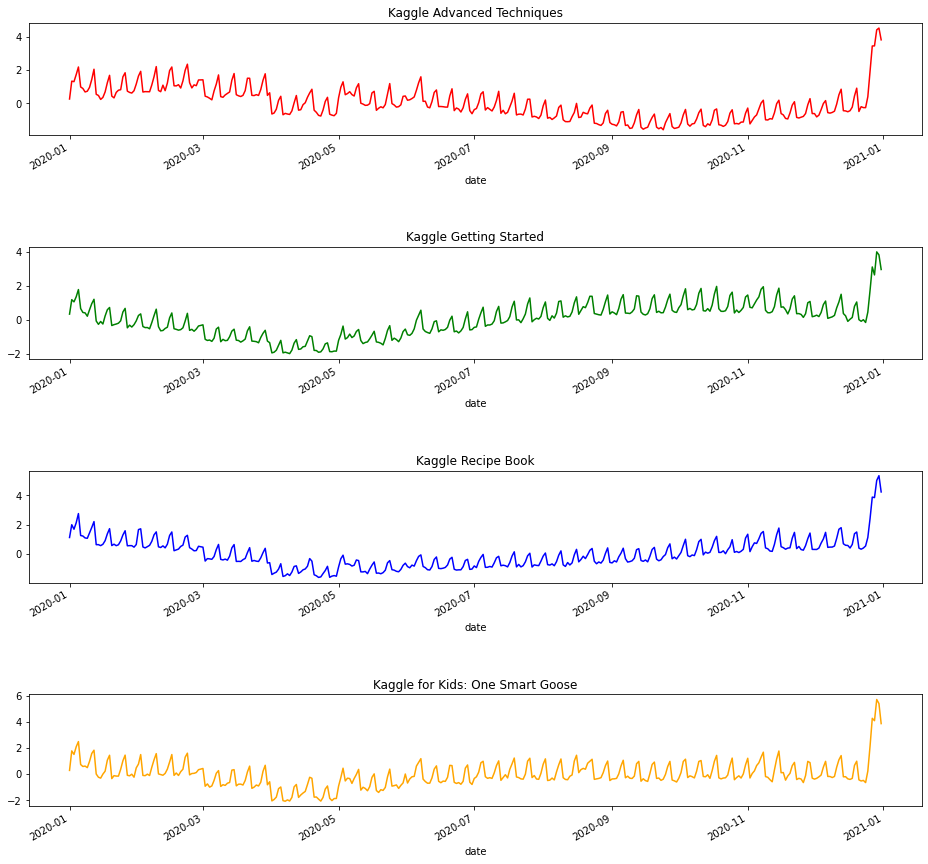

In [433]:
def plot_products(df):
  # Configure subplot 
  fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16,16), )
  axes[0].set_title("Kaggle Advanced Techniques")
  axes[0].set_xlabel("Dates")
  df["Kaggle Advanced Techniques"].plot(label="Kaggle Advanced Techniques", c = 'r', ax = axes[0])
  axes[1].set_title("Kaggle Getting Started")
  axes[1].set_xlabel("Dates")
  df["Kaggle Getting Started"].plot(label="Kaggle Getting Started", c = 'g', ax = axes[1])
  axes[2].set_title("Kaggle Recipe Book")
  axes[2].set_xlabel("Dates")
  df["Kaggle Recipe Book"].plot(label="Kaggle Recipe Book", c = 'b', ax = axes[2])
  axes[3].set_title("Kaggle for Kids: One Smart Goose")
  axes[3].set_xlabel("Dates")
  df["Kaggle for Kids: One Smart Goose"].plot(label="Kaggle for Kids: One Smart Goose", c = 'orange', ax = axes[3])
  fig.subplots_adjust(hspace=1)
plot_products(train_df_prep)

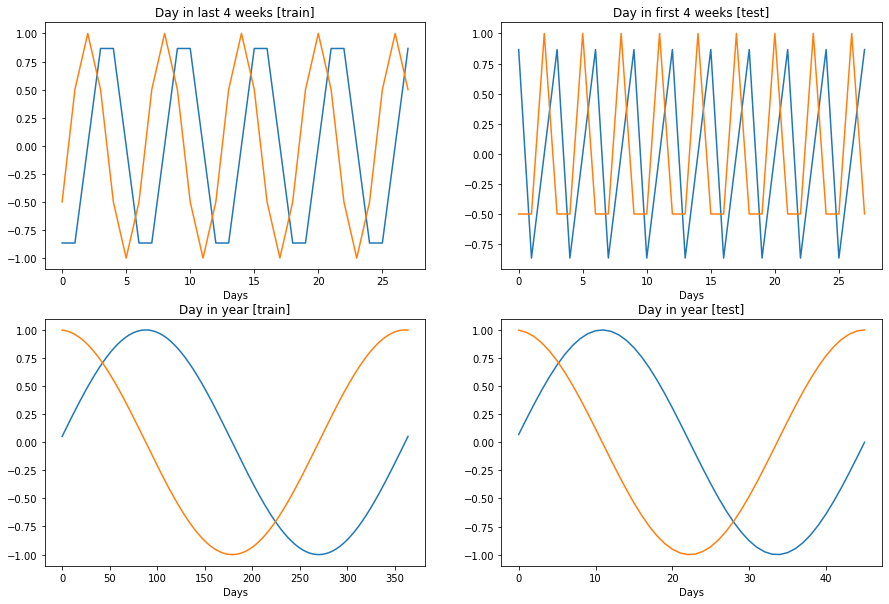

In [434]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
axes[0][0].set_title('Day in last 4 weeks [train]')
axes[0][0].set_xlabel('Days')
axes[0][0].plot(np.array(train_df_prep['week_sin'])[::1][-28:])
axes[0][0].plot(np.array(train_df_prep['week_cos'])[::1][-28:])
axes[0][1].set_title('Day in first 4 weeks [test]')
axes[0][1].set_xlabel('Days')
axes[0][1].plot(np.array(test_df_prep['week_sin'])[::8][:28])
axes[0][1].plot(np.array(test_df_prep['week_cos'])[::8][:28])
axes[1][0].set_title('Day in year [train]')
axes[1][0].set_xlabel('Days')
axes[1][0].plot(np.array(train_df_prep['year_sin'])[::1])
axes[1][0].plot(np.array(train_df_prep['year_cos'])[::1])
axes[1][1].set_title('Day in year [test]')
axes[1][1].set_xlabel('Days')
axes[1][1].plot(np.array(test_df_prep['year_sin'])[::8])
axes[1][1].plot(np.array(test_df_prep['year_cos'])[::8])

In [435]:
train_df_prep.shape

(365, 8)

In [436]:
train_df_prep.head()

,year_cos,year_sin,week_sin,week_cos,Kaggle Advanced Techniques,Kaggle Getting Started,Kaggle Recipe Book,Kaggle for Kids: One Smart Goose
date,,,,,,,,
2020-01-01,0.998659,0.051761,1.832554e-13,-1.0,0.263422,0.326315,1.112848,0.294669
2020-01-02,0.997617,0.068991,-8.660254e-01,-0.5,1.338081,1.178430,1.988336,1.791108
2020-01-03,0.996278,0.086200,-8.660254e-01,0.5,1.308146,1.050934,1.680058,1.519615
2020-01-04,0.994642,0.103384,-8.034921e-14,1.0,1.732176,1.350417,2.124044,2.106036
2020-01-05,0.992709,0.120537,8.660254e-01,0.5,2.189378,1.776221,2.751924,2.504807


### Create a Window Generator
- Source is [the official TF tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [437]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df_prep, test_df=test_df_prep,
               label_columns=None):
    
    # Store the raw data.
    self.train_df = train_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  def split_window(self, features):
    """ Split features into the actual inputs and labels. 

      E.g. features shape (batch, timesteps = total_window_size, features)
    """
    # Split input with timesteps = total_window_size into inputs and labels
    # by using their indices
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    # Only use the target columns as labels
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='Kaggle Advanced Techniques', max_subplots=3):
    """ Plot predictions or example for one target column"""
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Days')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    # Output is a dataset with batches of sequences
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    ds = ds.map(self.split_window)

    return ds


  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [438]:
w2 = WindowGenerator(input_width=14, 
                     label_width=14, 
                     shift=1, 
                     label_columns=["Kaggle Advanced Techniques",	
                                    "Kaggle Getting Started",	
                                    "Kaggle Recipe Book",	
                                    "Kaggle for Kids: One Smart Goose"])


# Example input to split_window = output from tf.keras.utils.timeseries_dataset_from_array()
# Here: 3 batches with 14 timestamps and all features
example_window = tf.stack([np.array(train_df_prep[:w2.total_window_size]),
                          np.array(train_df_prep[100:100+w2.total_window_size]),
                            np.array(train_df_prep[300:300+w2.total_window_size])])
example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 15, 8)
Inputs shape: (3, 14, 8)
Labels shape: (3, 14, 4)


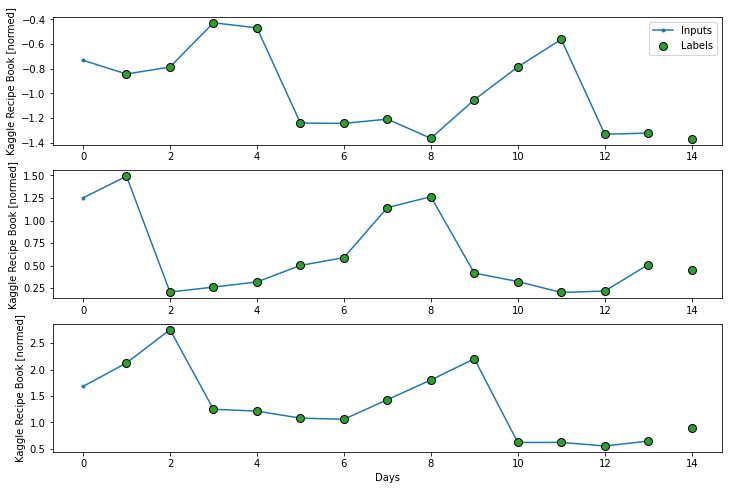

In [439]:
w2.plot(plot_col='Kaggle Recipe Book')

In [440]:
# One element in the training dataset
w2.train.element_spec

(TensorSpec(shape=(None, 14, 8), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 14, 4), dtype=tf.float32, name=None))

In [441]:
# Iterating yields batches
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 14, 8)
Labels shape (batch, time, features): (32, 14, 4)


### Util functions

In [478]:
def compile_and_fit(model, window, patience=2, epochs=20):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=epochs, callbacks=[early_stopping])
  return history

In [561]:
def run_inference(test_df_prep, train_df_prep, model, input_width, labels, expand_dim = False):
  """ Runs inference on test dataset 

      test_df_prep:   Prepared test dataframe
      train_df_prep:  Prepared train dataframe
      model:          Model to use for inference
      input_width:    Width of input per inference (e.g. 14 samples)
      labels:         Labels of target columns
  """
  # Model to use
  model = model
  # Copy test_df to allow multiple inferences
  test_df = test_df_prep.copy(deep=True)

  # Add target columns to test data
  for label_col in labels:
    test_df[label_col] = np.nan

  # Predict the individual days
  for test_idx in range(len(test_df)):
    # E.g. 14 inputs to predict model output. If test_idx = 0 -> 14 samples from train data
    train_data_samples = input_width - test_idx
    if train_data_samples > 0:
      train_data = train_df_prep.iloc[-train_data_samples:,:]
      test_data = test_df.iloc[:test_idx,:]
      inference_data = pd.concat([train_data,test_data])
    else:
      inference_data = test_df.iloc[test_idx-INPUT_WIDTH:test_idx,:]
    # Run inference
    if expand_dim:
      input = np.array(inference_data, dtype=np.float32)
      input = input.reshape(1, input.shape[0], input.shape[1])
      pred = model(input)
      # Add predicted values to the test dataframe
      test_df.iloc[test_idx,-4:] = pred[0][-1].numpy()
    else:
      pred = model(np.array(inference_data, dtype=np.float32))
      # Add predicted values to the test dataframe
      test_df.iloc[test_idx,-4:] = pred[-1].numpy()

  return test_df

In [545]:
def generate_submission(predictions, original_test_df, mean_psap, std_psap):
  """ Generate submission dataframe

      predictions: model predictions as output by `run_inference` function
      original_test_df: Initial test dataframe without preprocessing
      mean_psap: The mean per store and product as calculated during preprocessing
      std_psap: The std per store and product as calculated during preprocessing
  """
  predictions = predictions

  # Nested dataframes containing mean/std per store and product. 
  # Access via  mean = mean_per_product_and_store[<name_of_store>][<name_of_product>]
  # Access via  std = std_per_product_and_store[<name_of_store>][<name_of_product>]
  mean_psap = mean_psap["num_sold"]
  std_psap = std_psap["num_sold"]

  # Will contain lists of row_id and prediction
  submission = list()

  for idx, row in test_df.iterrows():
    date = row["date"]
    row_id = row["row_id"]
    store = row["store"]
    product = row["product"]
    country = row["country"]

    # Find row in prediction with same date
    prediction = predictions.loc[date][product]
    # Retrieve normalisation parameters
    mean = mean_psap[store][product]
    std = std_psap[store][product]

    # Undo normalisation
    prediction = int(np.round((prediction * std) + mean))

    # Append to submission
    submission.append([row_id, prediction])
  
  return pd.DataFrame(submission, columns=["row_id", "num_sold"])

def store_df(df, name):
  df.to_csv(name, index=False)

In [604]:
INPUT_WIDTH = 14
LABEL_WIDTH = 14
SHIFT = 1
LABEL_COLUMN_NAMES =["Kaggle Advanced Techniques",	
                     "Kaggle Getting Started",	
                     "Kaggle Recipe Book",	
                     "Kaggle for Kids: One Smart Goose"]

In [605]:
window = WindowGenerator(input_width=INPUT_WIDTH, 
                     label_width=LABEL_WIDTH, 
                     shift=SHIFT,
                     label_columns=LABEL_COLUMN_NAMES)
window.train.element_spec

(TensorSpec(shape=(None, 14, 8), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 14, 4), dtype=tf.float32, name=None))

## Train models

### 1.) Baseline model
```
linear baseline score: 30.24190
```

In [548]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=4)
])

### 2.) Dense model
```
dense without flatten score: 
dense with flatten score:
```

In [510]:
dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=4),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])
current_model = dense

### 2.) LSTM model
```
two lstm score 20 epochs: 10.39
two lstm with only one output 20 epochs: 12.05
```

In [627]:
lstm = tf.keras.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(4),
])
current_model = lstm

In [628]:
history = compile_and_fit(current_model, window, epochs=30)

Epoch 1/30
11/11 [==============================] - 9s 37ms/step - loss: 0.5503 - mean_absolute_error: 0.5782
Epoch 2/30
11/11 [==============================] - 0s 33ms/step - loss: 0.2945 - mean_absolute_error: 0.4177
Epoch 3/30
11/11 [==============================] - 0s 35ms/step - loss: 0.2610 - mean_absolute_error: 0.4069
Epoch 4/30
11/11 [==============================] - 0s 35ms/step - loss: 0.2392 - mean_absolute_error: 0.3887
Epoch 5/30
11/11 [==============================] - 0s 35ms/step - loss: 0.2214 - mean_absolute_error: 0.3727
Epoch 6/30
11/11 [==============================] - 1s 45ms/step - loss: 0.2002 - mean_absolute_error: 0.3559
Epoch 7/30
11/11 [==============================] - 0s 36ms/step - loss: 0.1775 - mean_absolute_error: 0.3346
Epoch 8/30
11/11 [==============================] - 0s 36ms/step - loss: 0.1500 - mean_absolute_error: 0.3049
Epoch 9/30
11/11 [==============================] - 0s 36ms/step - loss: 0.1222 - mean_absolute_error: 0.2685
Epoch 10/3

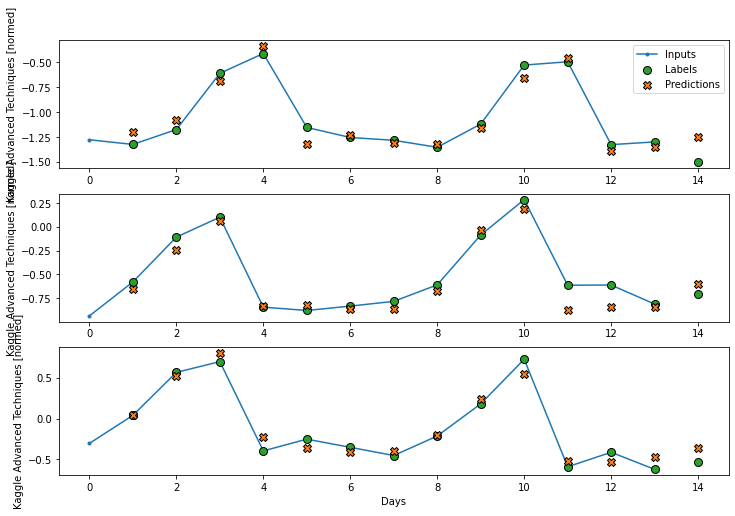

In [629]:
window.plot(current_model)

In [630]:
predictions_model = run_inference(test_df_prep, 
                                  train_df_prep, 
                                  current_model, 
                                  INPUT_WIDTH, 
                                  LABEL_COLUMN_NAMES, 
                                  expand_dim=True)

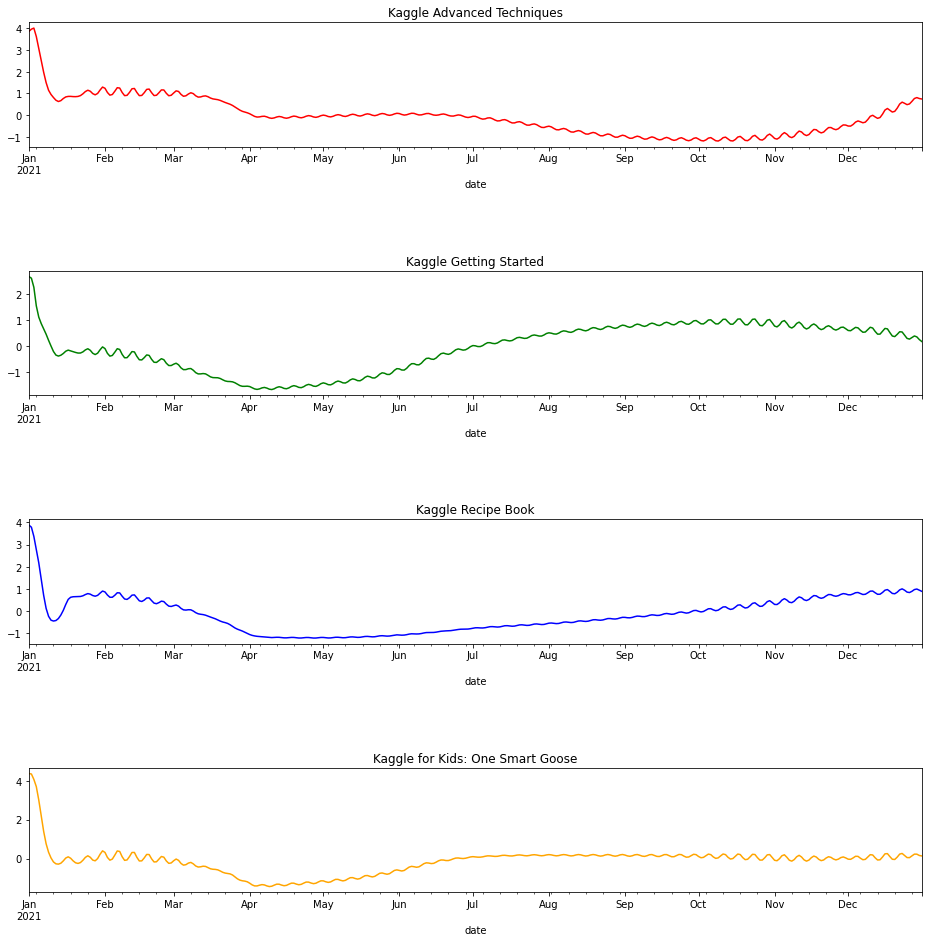

In [631]:
plot_products(predictions_model)

### Convert to submission format

In [632]:
submission = generate_submission(predictions_model, test_df, mean_per_product_and_store, std_per_product_and_store)

In [633]:
result = test_df.merge(submission, on='row_id', how='inner')

In [634]:
result.shape

(17520, 10)

In [635]:
result.head()

,row_id,date,country,store,product,week_sin,week_cos,year_sin,year_cos,num_sold
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,0.866025,-0.5,0.068991,0.997617,619
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,0.866025,-0.5,0.068991,0.997617,454
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,0.866025,-0.5,0.068991,0.997617,395
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,0.866025,-0.5,0.068991,0.997617,649
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,0.866025,-0.5,0.068991,0.997617,213


In [636]:
store_df(submission, os.path.join(".", "submissions", "lstm_overfit.csv"))